In [1]:
import os
os.environ['PYTHONWARNINGS'] = 'ignore'

import numpy as np
import pandas as pd

In [41]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore', message='pkg_resources is deprecated as an API')
warnings.filterwarnings('ignore', category=UserWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import sys
sys.path.append("..")

from src.EDA import load_data
from src.preprocessing import preprocess_data
from src.XGB import XGB_Model
from src.CatBoost import Cat_Boost_Model


In [ ]:
file_path = "../data/dirty_v3_path.csv"
df = load_data(file_path=file_path)

In [7]:
X_train, X_test, y_train, y_test, class_labels = preprocess_data(df=df)

X_train shape: (20400, 18)
X_test shape: (5100, 18)
y_train shape: (20400,)
y_test shape: (5100,)


100%|██████████| 100/100 [04:29<00:00,  2.70s/trial, best loss: -0.9237745098039216]
              precision    recall  f1-score   support

   Arthritis       0.77      0.71      0.74       359
      Asthma       0.94      0.91      0.92       407
      Cancer       0.98      0.98      0.98       247
    Diabetes       0.96      0.95      0.96      1284
     Healthy       0.99      0.99      0.99       608
Hypertension       0.90      0.92      0.91      1424
     Obesity       0.89      0.91      0.90       771

    accuracy                           0.92      5100
   macro avg       0.92      0.91      0.91      5100
weighted avg       0.92      0.92      0.92      5100

Accuracy: 0.9229411764705883


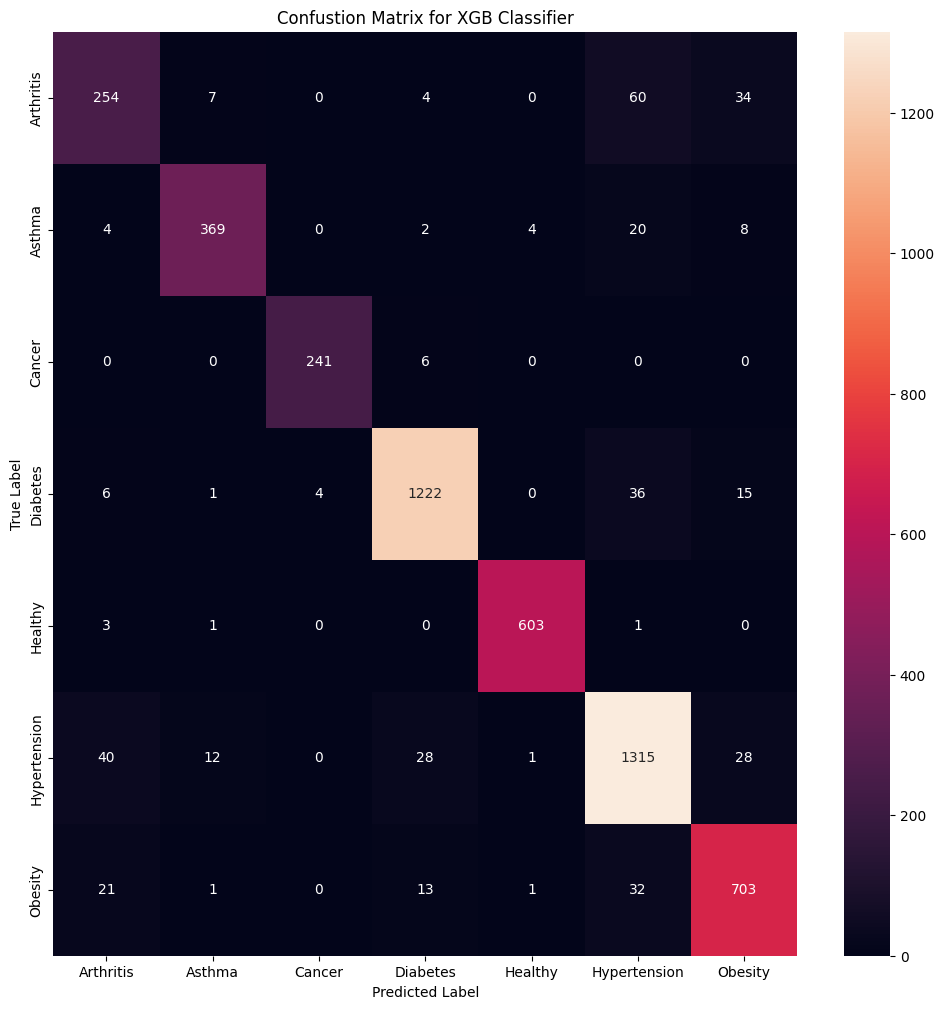

In [11]:
XGB_Classifier = XGB_Model(X_train, X_test, y_train, y_test, class_labels)

100%|██████████| 100/100 [1:05:31<00:00, 39.32s/trial, best loss: -0.9222578182438352]

--- Optimized CatBoost Hyperparameters ---
'bagging_temperature': 0.9800377597899806,
'border_count': 3,
'depth': 5.0,
'iterations': 700.0,
'l2_leaf_reg': 5.340505915176988,
'learning_rate': 0.05318241008750679,
'random_strength': 0.5300352198978647,
------------------------------------------
              precision    recall  f1-score   support

   Arthritis       0.81      0.72      0.76       359
      Asthma       0.94      0.91      0.92       407
      Cancer       0.99      0.98      0.98       247
    Diabetes       0.96      0.96      0.96      1284
     Healthy       0.99      0.99      0.99       608
Hypertension       0.90      0.93      0.91      1424
     Obesity       0.90      0.91      0.91       771

    accuracy                           0.93      5100
   macro avg       0.93      0.91      0.92      5100
weighted avg       0.93      0.93      0.93      5100

Accuracy: 0.926470588

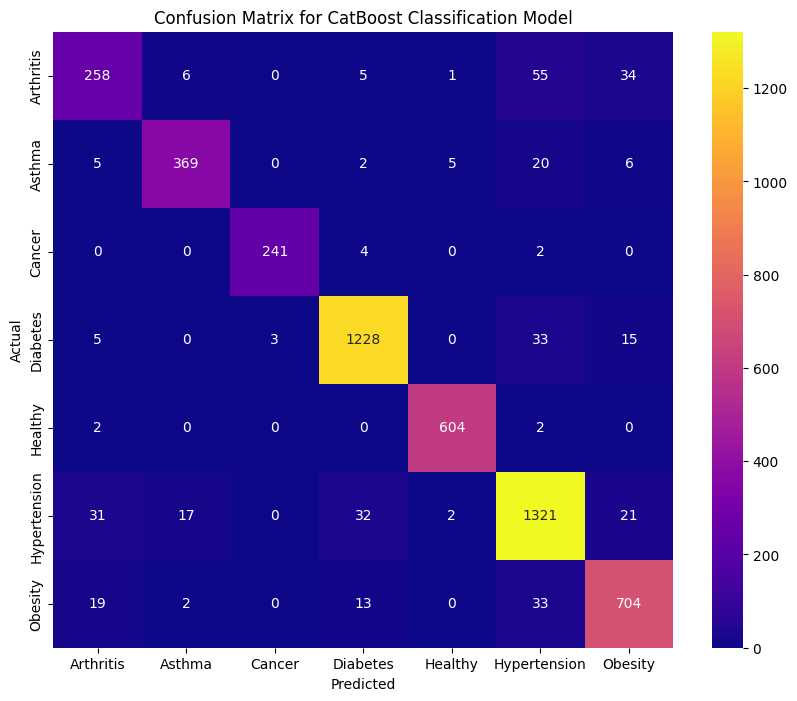

In [43]:
Cat_Boost_Classifier = Cat_Boost_Model(X_train, X_test, y_train, y_test, class_labels)

              precision    recall  f1-score   support

   Arthritis       0.80      0.72      0.76       359
      Asthma       0.95      0.91      0.93       407
      Cancer       0.98      0.98      0.98       247
    Diabetes       0.96      0.95      0.96      1284
     Healthy       0.99      0.99      0.99       608
Hypertension       0.90      0.93      0.92      1424
     Obesity       0.90      0.91      0.91       771

    accuracy                           0.93      5100
   macro avg       0.93      0.91      0.92      5100
weighted avg       0.93      0.93      0.93      5100

Accuracy: 0.9274509803921569


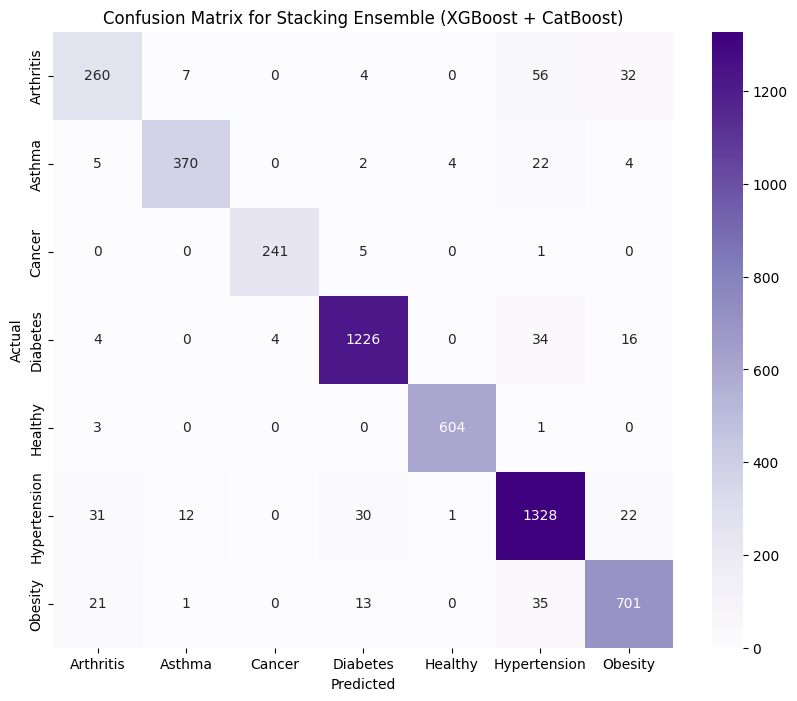

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

le = LabelEncoder()
le.fit(class_labels)

if np.issubdtype(y_train.dtype, np.number):
    y_train_encoded = y_train
else:
    y_train_encoded = le.transform(y_train)

estimators = [
    ('xgb', XGB_Classifier),
    ('cat', Cat_Boost_Classifier)
]

final_estimator = LogisticRegression(max_iter=1000)

stacking_ensemble = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    n_jobs=-1,
    passthrough=False, 
    cv=5
)

stacking_ensemble.fit(X_train, y_train_encoded)
y_pred_stack_encoded = stacking_ensemble.predict(X_test)
y_pred_stack = le.inverse_transform(y_pred_stack_encoded)

accuracy = accuracy_score(y_test, y_pred_stack)
print(classification_report(y_test, y_pred_stack, target_names=class_labels))
print(f"Accuracy: {accuracy}")


cm = confusion_matrix(y_test, y_pred_stack, labels=class_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True,     
    fmt='d',        
    cmap='Purples',
    cbar=True,
    xticklabels=class_labels, 
    yticklabels=class_labels
)
plt.title("Confusion Matrix for Stacking Ensemble (XGBoost + CatBoost)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()